# Melanoma Classification with Sequential Neural Network + PCA + Higher Initial Image Resolution (than 128)

In this notebook, a simple neural network based on the melanoma dataset will be build in order to assess initial performance.
The notebook works with data previously saved to the disk. To create this script, the model template was used.

The script that should be performed before this is the script: data_preparation_20192020.ipynb

<b>Running the script on cluster</b>

Please keep in mind the following
1. Load ALL images rather than a subset by changing to get_all_img_paths(img_folder) in Step 2 (get image paths 
2. The path to the data can be modified in Step 2 (get image paths + load data)
3. Make sure export is set to true
4. Save the results that are stored in the export folder and upload them seperately on google drive or github. The folder "export" is not tracked on github!!!

## 1. Set up

#### Set up for importing utilities

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

 #### Random State

In [2]:
from utilities import random_state
import numpy as np

random_state = random_state() 
seed = np.random.seed(random_state)

#### Export Config

In [3]:
export_results = True
on_cluster = False # there is some issue with h5py in the local env but it works on cluster so w/e
export_folder = f'export'

date_format = "%d%m%Y%H%M%S" # timestamp format in exported files
if export_results:
    import datetime
    import os
    if not os.path.exists(export_folder): 
      os.makedirs(export_folder)
      print("Created new directory %s" %export_folder)

#### img size config

In [4]:
img_pixel = 224 # default : 128

#### Timer

Start the timer

In [5]:
import time
start = time.time()

## 2. Get data

#### Data Config

In [6]:
base_path = "data" 
downsampled_data = False
current_train_melanoma_percentage = 0.08

#### Get image paths
For developing models on the cluster the max_images parameter should be removed. Instead call the method get_all_img_paths(img_folder).

In [7]:
from utilities import get_all_img_paths, get_img_paths

img_folder_train = base_path + "/train" + ("_downsampled" if downsampled_data else "")
img_folder_test = base_path + "/test" + ("_downsampled" if downsampled_data else "")
max_images_train = 500
max_images_test = 50

img_paths_train = get_img_paths(img_folder_train, max_images_train) 
img_paths_test = get_img_paths(img_folder_test, max_images_test)

#### Load data
Loads the images specified in img_paths into a data frame. This includes resizing the images and flattening them into an array and may take a while.

In [8]:
from utilities import load_train_test

groundtruth_file_train = base_path + "/ISIC_2020_2019_train" + ("_downsampled" if downsampled_data else "") + ".csv" 
groundtruth_file_test = base_path + "/ISIC_2020_2019_test" + ("_downsampled" if downsampled_data else "") + ".csv"

# available options
options = ["sequential", # first load train, then load test
           "parallel_train_test", # load train and test parallel (load data within train and test sequential)
           "sequential_train_test_parallel_chunks", # load first train, then test, but load the data within the sets parallel
           "parallel_fusion" # run train and test parallel and parallely load data with train and test 
          ]

# chose an option
option = "parallel_fusion"

df_train, df_test = load_train_test(img_paths_train, groundtruth_file_train, 
                                    img_paths_test, groundtruth_file_test, 
                                    option, img_pixel);

Num images per thread 55
start loading train
start thread #0 for train
start loading test
start thread #1 for train
start thread #0 for test
start thread #2 for train
start thread #3 for train
start thread #4 for train
start thread #5 for train
start thread #6 for train
start thread #7 for train
start thread #8 for train
finished thread #0 for test
done loading test
finished thread #0 for trainfinished thread #3 for train

finished thread #1 for train
finished thread #5 for train
finished thread #4 for train
finished thread #2 for train
finished thread #8 for train
finished thread #7 for train
finished thread #6 for train
done loading train


#### Split into target and predictors

In [9]:
from utilities import split_predictors_target

X_train, y_train = split_predictors_target(df_train) 
X_test, y_test = split_predictors_target(df_test) 

#### Clean up to save memory

In [10]:
del(df_train)
del(df_test)
del(img_paths_train)
del(img_paths_test)

## 3. Train model

#### PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)

X_train_reduced = pca.fit_transform(X_train,y_train)
X_test_reduced = pca.transform(X_test)

pca_components = pca.n_components_

In [12]:
print(f'PCA preserved information={sum(pca.explained_variance_ratio_)}')
print(f'PCA loss={1-sum(pca.explained_variance_ratio_)}')
print(f'PCA num components={pca_components}')
print(f'Initial num features={pca.n_features_}')
print(f'Ratio of features left={pca_components/pca.n_features_}')

PCA preserved information=0.9900366258222824
PCA loss=0.009963374177717643
PCA num components=219
Initial num features=150528


#### Function to build the model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam

from tensorflow.keras import backend as backend

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[pca_components], optimizer_type="rmsprop"):
    backend.clear_session() # pls oh mighty keras give us back our memory
    
    model = Sequential()
    
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    if optimizer_type=="rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_type=="adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type=="sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else: 
        optimizer = Nadam(learning_rate=learning_rate)
        
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', Recall(name="recall")])
    
    return model

#### Train model and find best params using RandomizedSearchCV

In [14]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.callbacks import ReduceLROnPlateau 

keras_class = KerasClassifier(build_model)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

melanoma_weight = (1/current_train_melanoma_percentage)/2

class_weight = {0: 1.,
                1: melanoma_weight,}

keras_class.fit(X_train_reduced, y_train, epochs=100, class_weight=class_weight,
              validation_data=(X_test_reduced, y_test),
              callbacks=[EarlyStopping(patience=10), lr_scheduler], verbose=0)
param_distribs = {
    "n_hidden": np.arange(1, 5),
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
    "optimizer_type": ["rmsprop", "adam", "sgd", "nadam"]
}
rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, random_state=random_state, verbose=0)

rnd_search_cv.fit(X_train_reduced, y_train, epochs=100, class_weight=class_weight,
                  validation_data=(X_test_reduced, y_test),
                  callbacks=[EarlyStopping(patience=10), lr_scheduler], verbose=0)

C:\Users\apfel\AppData\Local\Temp\ipykernel_13760\1363047249.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_class = KerasClassifier(build_model)


6/6 [==============================] - 1s 5ms/step - loss: 0.8519 - accuracy: 0.7952 - recall: 0.3077


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022D7D6A53A0>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022D7D6A57F0>,
                                        'n_hidden': array([1, 2, 3, 4]),
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'optimizer_type': ['rmsprop', 'adam',
                                                           'sgd', 'nadam']},
                

#### Investigate resulting model

In [15]:
print(f"Randomized Search CV best params={rnd_search_cv.best_params_}")
print(f"Randomized Search CV best score={rnd_search_cv.best_score_}")

if export_results:
    f = open(f'{export_folder}/best_params_{datetime.datetime.now().strftime(date_format)}.txt', 'w')
    f.write(str(rnd_search_cv.best_params_))
    f.close()

Randomized Search CV best params={'learning_rate': 0.0051747964719537, 'n_hidden': 4, 'n_neurons': 55, 'optimizer_type': 'nadam'}
Randomized Search CV best score=0.8079744180043539


In [16]:
model = rnd_search_cv.best_estimator_.model
history = rnd_search_cv.best_estimator_.model.history

In [17]:
# print out model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 55)                12100     
                                                                 
 dense_1 (Dense)             (None, 55)                3080      
                                                                 
 dense_2 (Dense)             (None, 55)                3080      
                                                                 
 dense_3 (Dense)             (None, 55)                3080      
                                                                 
 dense_4 (Dense)             (None, 1)                 56        
                                                                 
Total params: 21,396
Trainable params: 21,396
Non-trainable params: 0
_________________________________________________________________


#### Store the model

In [18]:
# store model
if export_results and on_cluster:
    model.save(export_folder + "/model_"+datetime.datetime.now().strftime(date_format)+".h5")

#### Timer
Stop the timer

In [19]:
stop = time.time()
print(f'It took {stop - start} s to load the data and train the model')

if export_results:
    f = open(f'{export_folder}/overall_time_{datetime.datetime.now().strftime(date_format)}.txt', 'w')
    f.write(f'Time it took : {stop - start} s')
    f.close()

It took 250.46966695785522 s to load the data and train the model


#### Clean up to save memory

In [20]:
del(rnd_search_cv)
del(keras_class)

## 4. Test model

#### Evaluate resulting model

In [21]:
# evaluate the model
_, train_acc, train_recall = model.evaluate(X_train_reduced, y_train)
_, test_acc, test_recall  = model.evaluate(X_test_reduced, y_test)

print('Accuracy\tTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Recall\tTrain: %.3f, Test: %.3f' % (train_recall, test_recall))

2/2 [==============================] - 0s 3ms/step - loss: 1.3825 - accuracy: 0.8800 - recall: 0.5000
Accuracy	Train: 1.000, Test: 0.880
Recall	Train: 1.000, Test: 0.500


#### Clean up to save memory

In [22]:
del(X_train)
del(X_train_reduced)
del(y_train)

#### Plot loss, accuracy and recall during training

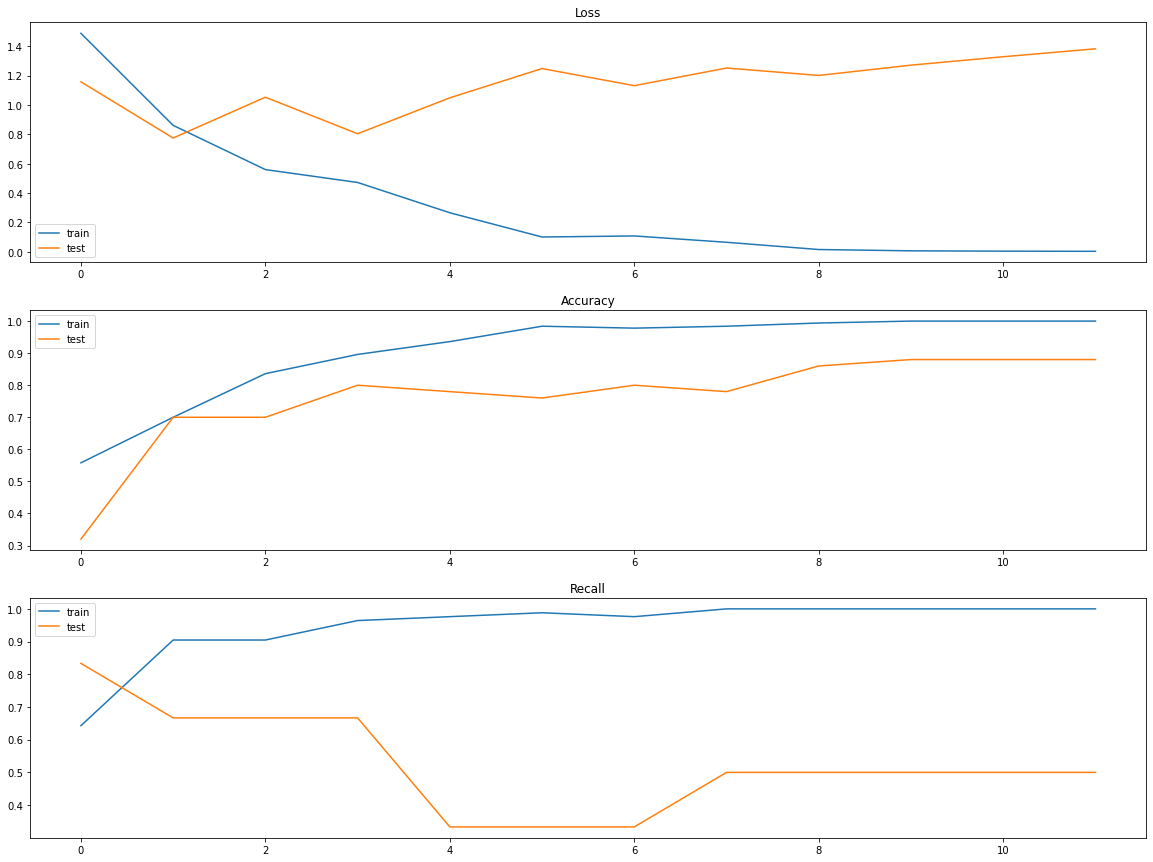

In [23]:
from matplotlib import pyplot

_, axs = pyplot.subplots(3, 1, figsize=(20,15))

# plot loss during training
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='test')
axs[0].set_title("Loss")
axs[0].legend()

# plot accuracy during training
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='test')
axs[1].set_title("Accuracy")
axs[1].legend()

# plot recall during training
axs[2].plot(history.history['recall'], label='train')
axs[2].plot(history.history['val_recall'], label='test')
axs[2].set_title("Recall")
axs[2].legend()

if export_results:
    pyplot.savefig(export_folder + "/loss_and_accuracy_during_training_"+datetime.datetime.now().strftime(date_format)+".png")

pyplot.show()

#### Predict test set

In [24]:
y_pred_continuous = model.predict(X_test_reduced)
y_pred_discrete = (model.predict(X_test_reduced) > 0.5).astype("int32")
y_pred = y_pred_discrete

#### Print classification report

In [25]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, digits=4)
print(f'\nClassification_report=\n{report}')

if export_results:
    file = open(export_folder + "/classification_report_"+datetime.datetime.now().strftime(date_format)+".txt", 'w')
    file.write(report)
    file.close()


Classification_report=
              precision    recall  f1-score   support

           0     0.9318    0.9318    0.9318        44
           1     0.5000    0.5000    0.5000         6

    accuracy                         0.8800        50
   macro avg     0.7159    0.7159    0.7159        50
weighted avg     0.8800    0.8800    0.8800        50



#### Confusion Matrix

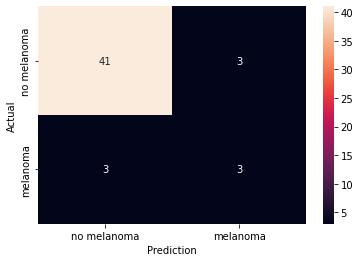

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ["no melanoma", "melanoma"]

cf = confusion_matrix(y_test, y_pred)
plot = sns.heatmap(cf, annot= True, fmt=".0f",
           xticklabels = class_names,
           yticklabels = class_names)
plot.set(xlabel='Prediction', ylabel='Actual')

if export_results:
    plot.get_figure().savefig(export_folder + '/confusion_matrix_' + datetime.datetime.now().strftime(date_format) + ".png")

#### Reverse PCA to be able to display results

In [27]:
import pandas as pd

X_test = pca.inverse_transform(X_test_reduced)
X_test = pd.DataFrame(X_test, dtype="float", columns = ['pixel' + str(i + 1) for i in range(X_test.shape[1])])

#### Display images and predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


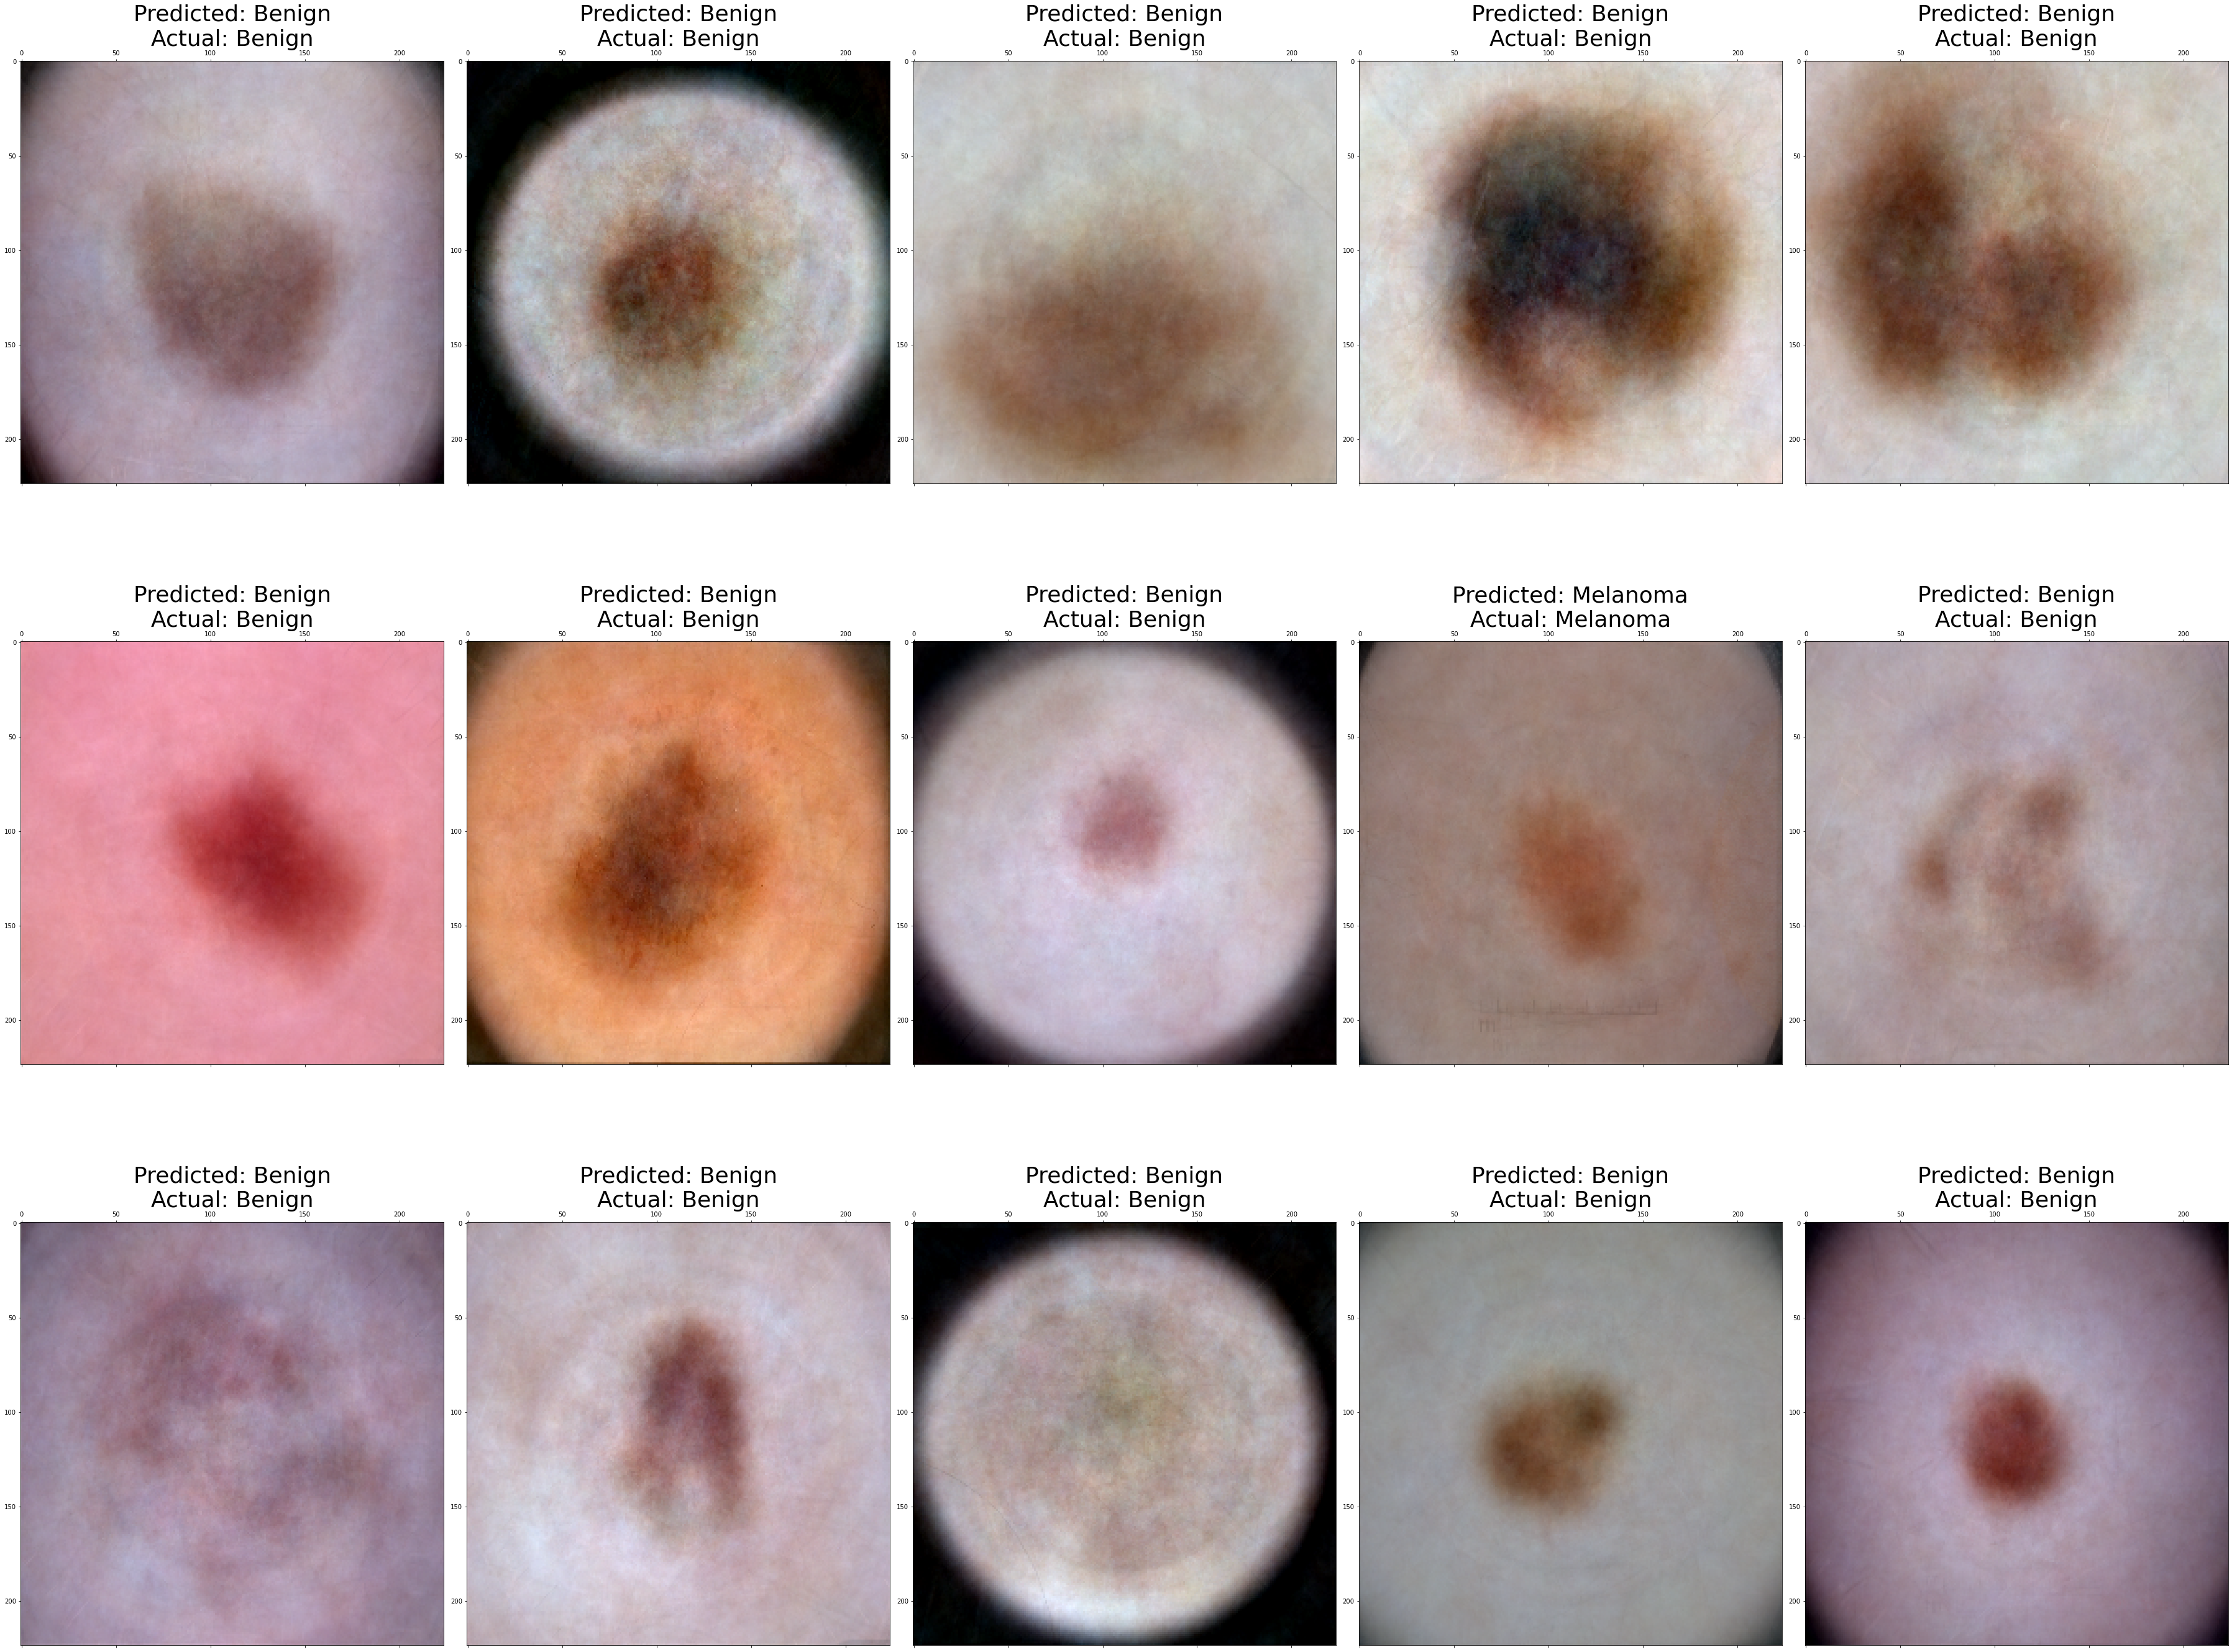

In [28]:
from utilities import display_results

plt_all = display_results(X_test, y_pred, y_test, 15, img_pixel=img_pixel)

if export_results:
    plt_all.savefig(export_folder + "/classification_results_"+datetime.datetime.now().strftime(date_format)+".png")

plt_all.show()

#### Display wrongly classified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


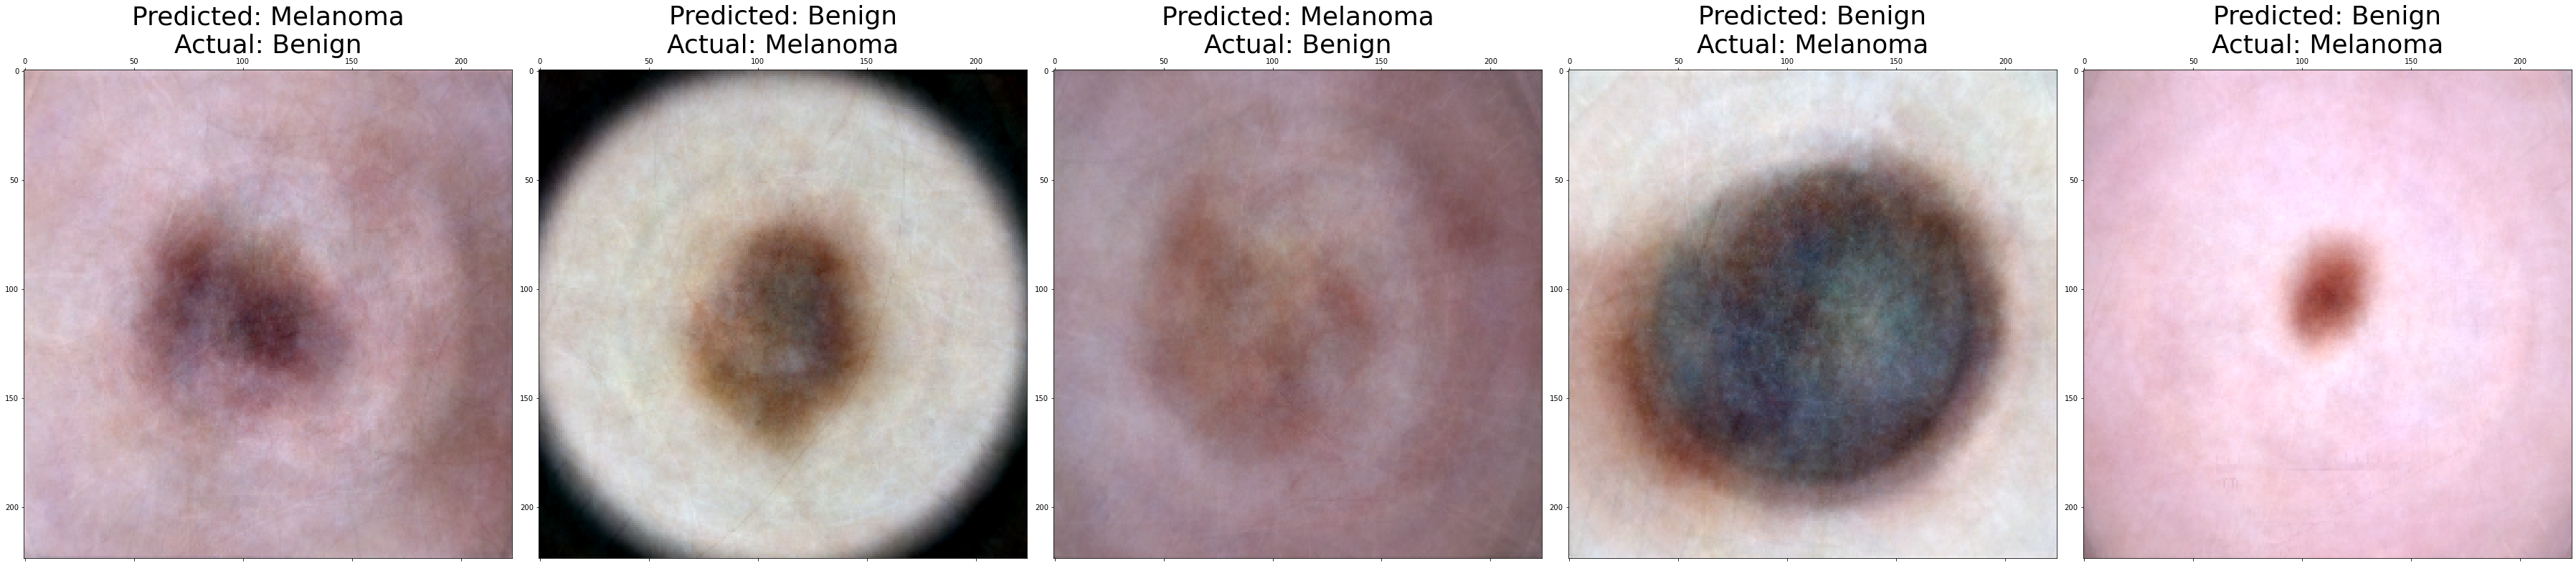

In [29]:
from utilities import display_interesting_results

plt_wrong = display_interesting_results(X_test, y_pred, y_test, img_pixel=img_pixel)

if export_results:
    plt_wrong.savefig(export_folder + "/incorrect_classification_results_"+datetime.datetime.now().strftime(date_format)+".png")
    
plt_wrong.show()